In [1]:
import sys
import os

sys.path.append('../../')

import keras_tuner as kt
from keras.callbacks import EarlyStopping
from src.data_utils import prepare_dataset

Using TensorFlow backend


# Define Hyperparams Search Space

In [2]:
def build_model(hp):
    # Hyperparameters of model architecture
    img_size = 224 # VGG19 input size

    num_dense_layers = hp.Int('num_dense_layers', min_value=2, max_value=3, step=1)
    dense_units_list = [hp.Int(f'dense_units_{i + 1}', min_value=32, max_value=96, step=16, default=64)
                        for i in range(num_dense_layers)]
    dense_activation_list = [hp.Choice(f'dense_activation_{i + 1}', values=['relu', 'tanh', 'sigmoid', 'linear'],default='relu')
                             for i in range(num_dense_layers)]
    dropout_rate_list = [hp.Float(f'dropout_rate_{i + 1}', min_value=0.1, max_value=0.5, step=0.1, default=0.3)
                         for i in range(num_dense_layers)]
    score_activation = hp.Choice('score_activation', values=['relu', 'tanh', 'sigmoid', 'linear'])
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=0, max_value=4, step=1, default=4)
    final_activation = hp.Choice('final_activation', values=['tanh', 'sigmoid'], default='sigmoid')

    # Build the model
    meta_model = create_meta_network(img_size, num_dense_layers, dense_units_list, dense_activation_list,
                                     dropout_rate_list,
                                     score_activation, unfreeze_layers, final_activation, data_aug=True, weights=None)

    # Hyperparameters of model training
    optimizers = {
        'adam': Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        'sgd': SGD(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        'rmsprop': RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6]))
    }

    meta_model.compile(optimizer=optimizers[hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])],
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    return meta_model

build_model(kt.HyperParameters())

# Define Tuner

In [3]:
from datetime import date, datetime
# Set the seed for data shuffling based on date and time
today = date.today().strftime("%Y%m%d")
time = datetime.now().strftime("%H%M%S")
data_shuffle_seed = int(f'{today}{time}')
print('data_shuffle_seed: ', data_shuffle_seed)

hypermodel_tuning_dir = 'hypermodel_tuning'
project_name = "BayesianOptimization_{}".format(data_shuffle_seed)

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=100,
    # num_initial_points=None,
    # alpha=0.0001,
    # beta=2.6,
    # seed=None,
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    # max_retries_per_trial=0,
    # max_consecutive_failed_trials=3,
    overwrite=False,
    directory=hypermodel_tuning_dir,
    project_name=project_name,
)

tuner.search_space_summary()

Search space summary
Default search space size: 12
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
score_activation (Choice)
{'default': 'relu', 'conditions

# Data Preparation

In [4]:
question_idx = 1

dataset = prepare_dataset(duel_results_path=f'../../data/duel_results/duels_question_{question_idx}.csv',
                          images_dir='../../data/Mapillary_data/Sample_web_green',
                          model_type='ranking',
                          image_size=(224, 224),
                          shuffle=True,
                          seed=data_shuffle_seed)

x_train, y_train = dataset['train']['x'], dataset['train']['y']
x_test, y_test = dataset['test']['x'], dataset['test']['y']
x_validation, y_validation = dataset['validation']['x'], dataset['validation']['y']

Processing Duels: 100%|██████████| 4563/4563 [00:55<00:00, 82.53it/s] 


In total 4563 duels processed.
Dataset shuffled.


# Start Searching

In [8]:
tuner.search(x=x_train,
             y=y_train,
             epochs=50,
             batch_size=32,
             validation_data=(x_validation, y_validation),
             callbacks=[EarlyStopping(monitor='val_accuracy', 
                                      patience=10, 
                                      baseline=0.80,
                                      restore_best_weights=True)])

Trial 100 Complete [00h 04m 42s]
val_accuracy: 0.8499452471733093

Best val_accuracy So Far: 0.8608981370925903
Total elapsed time: 05h 12m 54s


# Print the Search Space

In [9]:
tuner.search_space_summary()

project_dir = f'{hypermodel_tuning_dir}/{project_name}'
os.makedirs(project_dir, exist_ok=True)

with open(f'{project_dir}/search_space.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.search_space_summary()))
    sys.stdout = original_stdout
    f.close()


Search space summary
Default search space size: 15
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 16, 'sampling': 'linear'}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
dense_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'linear'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
score_activation (Choice)
{'default': 'relu', 'conditions

# Query the Search Results

In [10]:
tuner.results_summary()

with open(f'{project_dir}/results_summary.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.results_summary()))
    sys.stdout = original_stdout
    f.close()

Results summary
Results in hypermodel_tuning\BayesianOptimization_2023-10-06_21-00
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 084 summary
Hyperparameters:
num_dense_layers: 2
dense_units_1: 48
dense_units_2: 32
dense_activation_1: linear
dense_activation_2: linear
dropout_rate_1: 0.30000000000000004
dropout_rate_2: 0.5
score_activation: linear
unfreeze_layers: 0
final_activation: sigmoid
learning_rate: 0.0001
optimizer: adam
dense_units_3: 32
dense_activation_3: tanh
dropout_rate_3: 0.30000000000000004
Score: 0.8608981370925903

Trial 089 summary
Hyperparameters:
num_dense_layers: 2
dense_units_1: 96
dense_units_2: 32
dense_activation_1: linear
dense_activation_2: linear
dropout_rate_1: 0.4
dropout_rate_2: 0.5
score_activation: linear
unfreeze_layers: 0
final_activation: sigmoid
learning_rate: 0.0001
optimizer: adam
dense_units_3: 32
dense_activation_3: sigmoid
dropout_rate_3: 0.5
Score: 0.8598028421401978

Trial 096 summary
Hyperparameters:
num_dense

# Save the best models with weights, hyperparameters defined in the search space and model architectures 

In [24]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)
best_models = tuner.get_best_models(num_models=10)

import json
for i in range(len(best_models)):
    # save the weighted models 
    best_models[i].save(f'{project_dir}/best_model_{i+1}.keras')
    
    # save the hyperparameters defined in the search space
    with open(f'{project_dir}/best_hps_{i+1}.json', 'w') as f:
        json.dump(best_hps[i].values, f, indent=4)
    
    # save the model architecture
    best_model_architecture = build_model(best_hps[i])
    with open(f'{project_dir}/best_model_architecture_{i+1}.json', 'w') as f:
        f.write(best_model_architecture.to_json(indent=4))
        f.close()

# Retrain the best models

Epoch 1/50
86/86 [==============================] - 21s 233ms/step - loss: 0.7456 - accuracy: 0.7278 - val_loss: 0.4747 - val_accuracy: 0.8226
Epoch 2/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5880 - accuracy: 0.7654 - val_loss: 0.4892 - val_accuracy: 0.8127
Epoch 3/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5543 - accuracy: 0.7753 - val_loss: 0.3729 - val_accuracy: 0.8215
Epoch 4/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5163 - accuracy: 0.8067 - val_loss: 0.4172 - val_accuracy: 0.8160
Epoch 5/50
86/86 [==============================] - 20s 227ms/step - loss: 0.5266 - accuracy: 0.7877 - val_loss: 0.3879 - val_accuracy: 0.8248
Epoch 6/50
86/86 [==============================] - 19s 227ms/step - loss: 0.5214 - accuracy: 0.7804 - val_loss: 0.4207 - val_accuracy: 0.8291
Epoch 7/50
86/86 [==============================] - 19s 227ms/step - loss: 0.4756 - accuracy: 0.8020 - val_loss: 0.3871 - val_accuracy: 0.8313

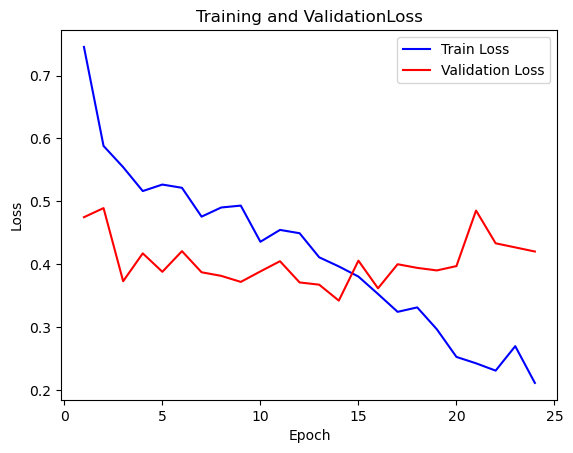

Figure Training and ValidationAccuracy saved!


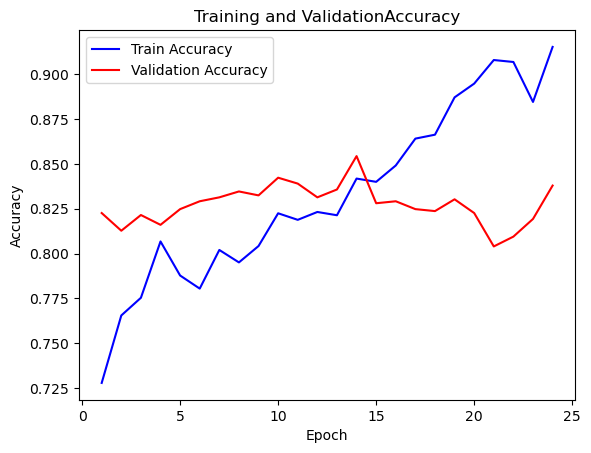

Model 1 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 232ms/step - loss: 0.7242 - accuracy: 0.7300 - val_loss: 0.9269 - val_accuracy: 0.7744
Epoch 2/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5867 - accuracy: 0.7621 - val_loss: 0.3952 - val_accuracy: 0.8061
Epoch 3/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5532 - accuracy: 0.7735 - val_loss: 0.3743 - val_accuracy: 0.8401
Epoch 4/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5290 - accuracy: 0.7921 - val_loss: 0.3862 - val_accuracy: 0.8302
Epoch 5/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5000 - accuracy: 0.7965 - val_loss: 0.3781 - val_accuracy: 0.8204
Epoch 6/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5011 - accuracy: 0.7936 - val_loss: 0.3958 - val_accuracy: 0.8182
Epoch 7/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4838 - accuracy: 0.7969 - val_los

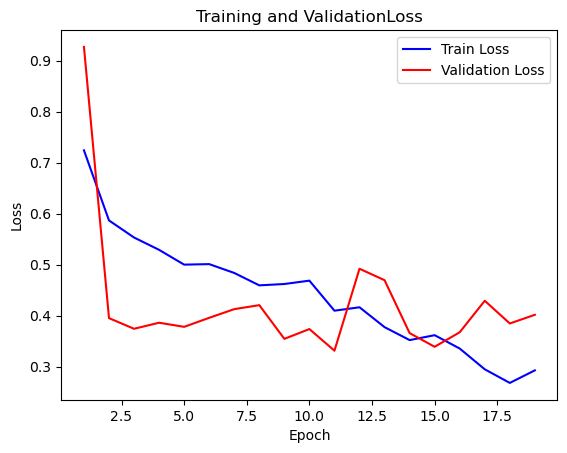

Figure Training and ValidationAccuracy saved!


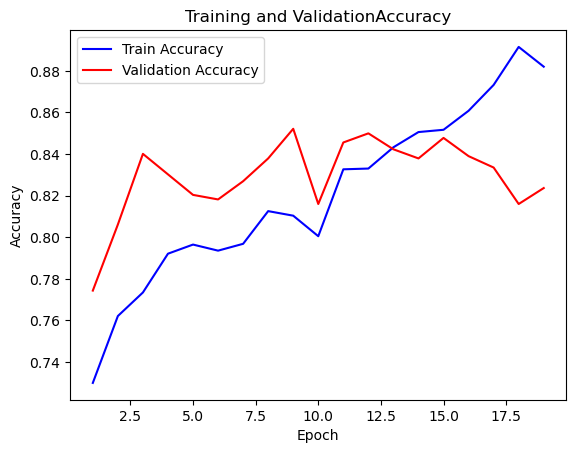

Model 2 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 229ms/step - loss: 0.6142 - accuracy: 0.7483 - val_loss: 0.4080 - val_accuracy: 0.8291
Epoch 2/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5020 - accuracy: 0.7848 - val_loss: 0.3812 - val_accuracy: 0.8302
Epoch 3/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4916 - accuracy: 0.7877 - val_loss: 0.4226 - val_accuracy: 0.8193
Epoch 4/50
86/86 [==============================] - 19s 224ms/step - loss: 0.4651 - accuracy: 0.8045 - val_loss: 0.3785 - val_accuracy: 0.8226
Epoch 5/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4312 - accuracy: 0.8056 - val_loss: 0.3985 - val_accuracy: 0.8434
Epoch 6/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4435 - accuracy: 0.8042 - val_loss: 0.3528 - val_accuracy: 0.8379
Epoch 7/50
86/86 [==============================] - 19s 224ms/step - loss: 0.3804 - accuracy: 0.8330 - val_los

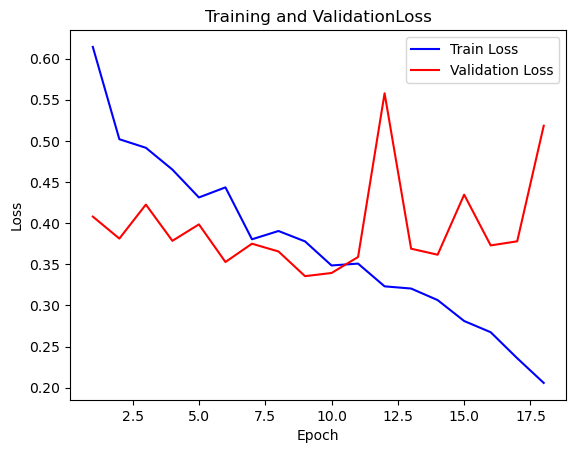

Figure Training and ValidationAccuracy saved!


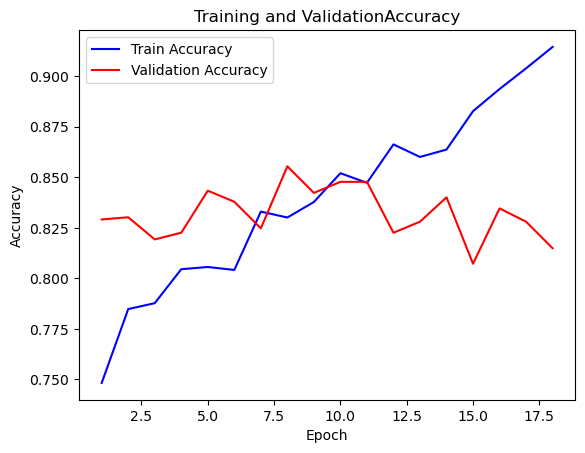

Model 3 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 229ms/step - loss: 0.6754 - accuracy: 0.7315 - val_loss: 0.5587 - val_accuracy: 0.8237
Epoch 2/50
86/86 [==============================] - 19s 224ms/step - loss: 0.5162 - accuracy: 0.7779 - val_loss: 0.3857 - val_accuracy: 0.8346
Epoch 3/50
86/86 [==============================] - 19s 224ms/step - loss: 0.5208 - accuracy: 0.7881 - val_loss: 0.3688 - val_accuracy: 0.8269
Epoch 4/50
86/86 [==============================] - 19s 224ms/step - loss: 0.4872 - accuracy: 0.7921 - val_loss: 0.3807 - val_accuracy: 0.8346
Epoch 5/50
86/86 [==============================] - 19s 224ms/step - loss: 0.4781 - accuracy: 0.7936 - val_loss: 0.3811 - val_accuracy: 0.8445
Epoch 6/50
86/86 [==============================] - 19s 224ms/step - loss: 0.4459 - accuracy: 0.8104 - val_loss: 0.3415 - val_accuracy: 0.8499
Epoch 7/50
86/86 [==============================] - 19s 224ms/step - loss: 0.4456 - accuracy: 0.8020 - val_los

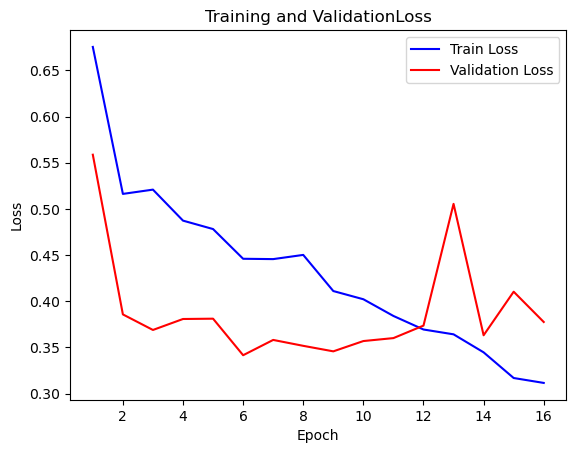

Figure Training and ValidationAccuracy saved!


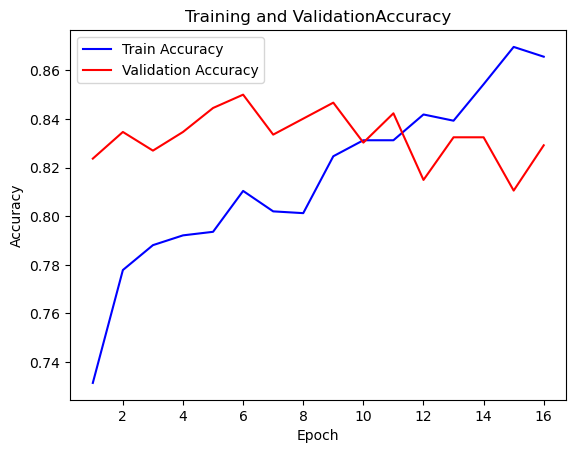

Model 4 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 231ms/step - loss: 0.5257 - accuracy: 0.7453 - val_loss: 0.6283 - val_accuracy: 0.7185
Epoch 2/50
86/86 [==============================] - 19s 226ms/step - loss: 0.4907 - accuracy: 0.7830 - val_loss: 0.6429 - val_accuracy: 0.7514
Epoch 3/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4949 - accuracy: 0.7808 - val_loss: 0.6931 - val_accuracy: 0.5115
Epoch 4/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4847 - accuracy: 0.7976 - val_loss: 0.5930 - val_accuracy: 0.7448
Epoch 5/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4720 - accuracy: 0.8133 - val_loss: 0.4839 - val_accuracy: 0.8182
Epoch 6/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4694 - accuracy: 0.8012 - val_loss: 0.5036 - val_accuracy: 0.8226
Epoch 7/50
86/86 [==============================] - 19s 224ms/step - loss: 0.4572 - accuracy: 0.8115 - val_los

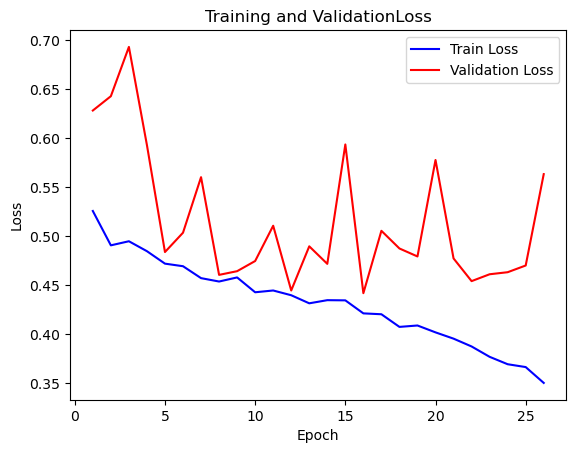

Figure Training and ValidationAccuracy saved!


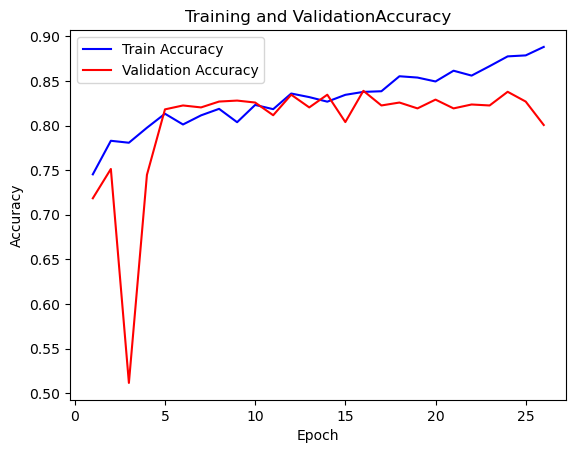

Model 5 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 232ms/step - loss: 0.7178 - accuracy: 0.7041 - val_loss: 0.4609 - val_accuracy: 0.8105
Epoch 2/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5851 - accuracy: 0.7614 - val_loss: 0.4383 - val_accuracy: 0.8116
Epoch 3/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5571 - accuracy: 0.7706 - val_loss: 0.3893 - val_accuracy: 0.8248
Epoch 4/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5020 - accuracy: 0.7852 - val_loss: 0.3683 - val_accuracy: 0.8335
Epoch 5/50
86/86 [==============================] - 19s 226ms/step - loss: 0.4957 - accuracy: 0.7925 - val_loss: 0.3944 - val_accuracy: 0.8171
Epoch 6/50
86/86 [==============================] - 19s 226ms/step - loss: 0.4792 - accuracy: 0.7991 - val_loss: 0.5840 - val_accuracy: 0.8039
Epoch 7/50
86/86 [==============================] - 20s 227ms/step - loss: 0.4932 - accuracy: 0.7863 - val_los

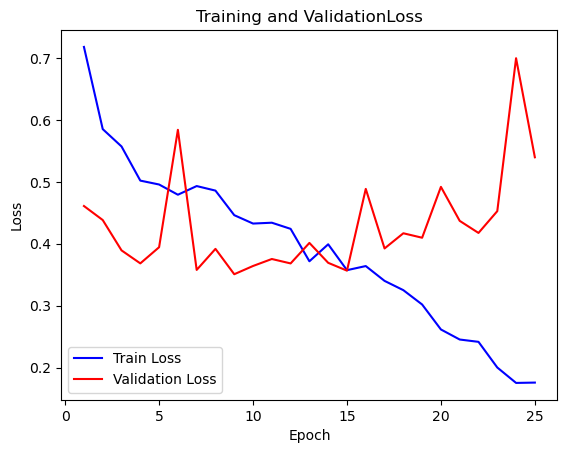

Figure Training and ValidationAccuracy saved!


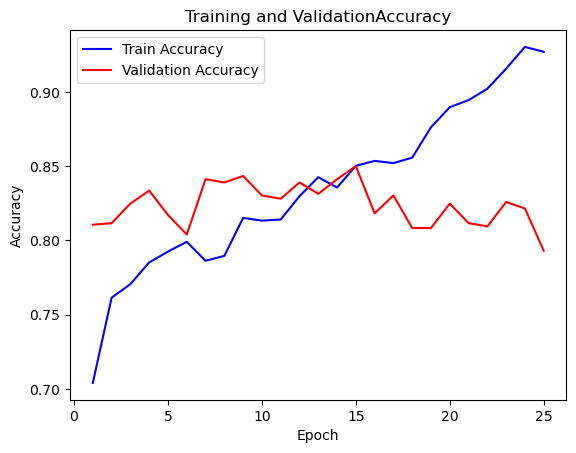

Model 6 training results saved.
Epoch 1/50
86/86 [==============================] - 9s 90ms/step - loss: 0.6067 - accuracy: 0.6949 - val_loss: 0.5812 - val_accuracy: 0.7842
Epoch 2/50
86/86 [==============================] - 7s 84ms/step - loss: 0.5600 - accuracy: 0.7651 - val_loss: 0.5552 - val_accuracy: 0.8007
Epoch 3/50
86/86 [==============================] - 7s 84ms/step - loss: 0.5486 - accuracy: 0.7881 - val_loss: 0.5470 - val_accuracy: 0.8171
Epoch 4/50
86/86 [==============================] - 7s 85ms/step - loss: 0.5365 - accuracy: 0.8126 - val_loss: 0.5428 - val_accuracy: 0.8237
Epoch 5/50
86/86 [==============================] - 7s 84ms/step - loss: 0.5335 - accuracy: 0.8148 - val_loss: 0.5398 - val_accuracy: 0.8149
Epoch 6/50
86/86 [==============================] - 7s 84ms/step - loss: 0.5267 - accuracy: 0.8268 - val_loss: 0.5385 - val_accuracy: 0.8149
Epoch 7/50
86/86 [==============================] - 7s 84ms/step - loss: 0.5227 - accuracy: 0.8272 - val_loss: 0.5387 - va

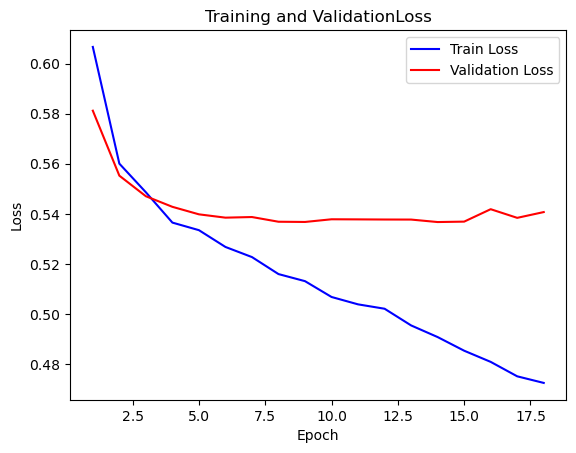

Figure Training and ValidationAccuracy saved!


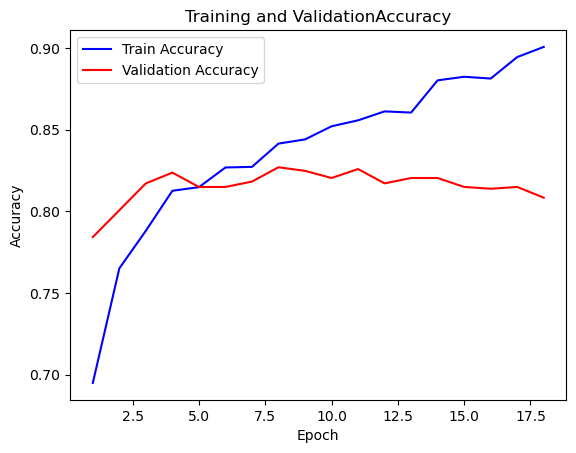

Model 7 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 232ms/step - loss: 0.5610 - accuracy: 0.7625 - val_loss: 0.5707 - val_accuracy: 0.7985
Epoch 2/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5451 - accuracy: 0.7877 - val_loss: 0.6260 - val_accuracy: 0.8171
Epoch 3/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5420 - accuracy: 0.7921 - val_loss: 0.5326 - val_accuracy: 0.8171
Epoch 4/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5381 - accuracy: 0.8005 - val_loss: 0.5373 - val_accuracy: 0.8061
Epoch 5/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5365 - accuracy: 0.8078 - val_loss: 0.5609 - val_accuracy: 0.8116
Epoch 6/50
86/86 [==============================] - 19s 226ms/step - loss: 0.5325 - accuracy: 0.8075 - val_loss: 0.5412 - val_accuracy: 0.8269
Epoch 7/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5304 - accuracy: 0.8078 - val_los

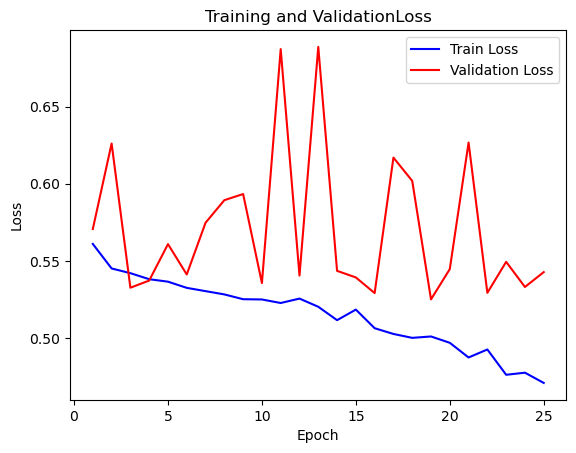

Figure Training and ValidationAccuracy saved!


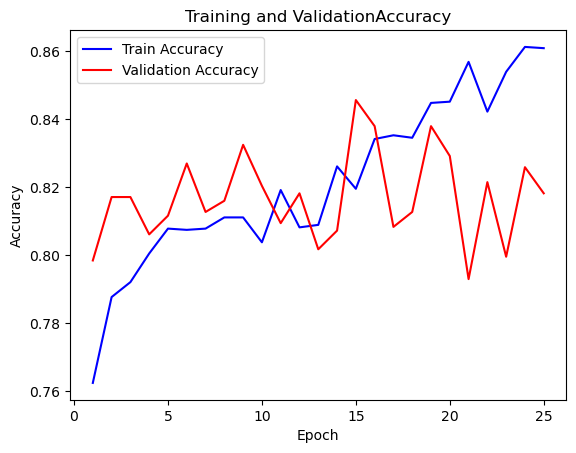

Model 8 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 232ms/step - loss: 0.7041 - accuracy: 0.7106 - val_loss: 0.6590 - val_accuracy: 0.6298
Epoch 2/50
86/86 [==============================] - 19s 227ms/step - loss: 0.5989 - accuracy: 0.7468 - val_loss: 0.4381 - val_accuracy: 0.8061
Epoch 3/50
86/86 [==============================] - 20s 229ms/step - loss: 0.5596 - accuracy: 0.7662 - val_loss: 0.4928 - val_accuracy: 0.8083
Epoch 4/50
86/86 [==============================] - 20s 229ms/step - loss: 0.5428 - accuracy: 0.7691 - val_loss: 0.3893 - val_accuracy: 0.8248
Epoch 5/50
86/86 [==============================] - 20s 227ms/step - loss: 0.5170 - accuracy: 0.7852 - val_loss: 0.3768 - val_accuracy: 0.8258
Epoch 6/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5180 - accuracy: 0.7768 - val_loss: 0.3983 - val_accuracy: 0.8116
Epoch 7/50
86/86 [==============================] - 20s 228ms/step - loss: 0.4940 - accuracy: 0.7837 - val_los

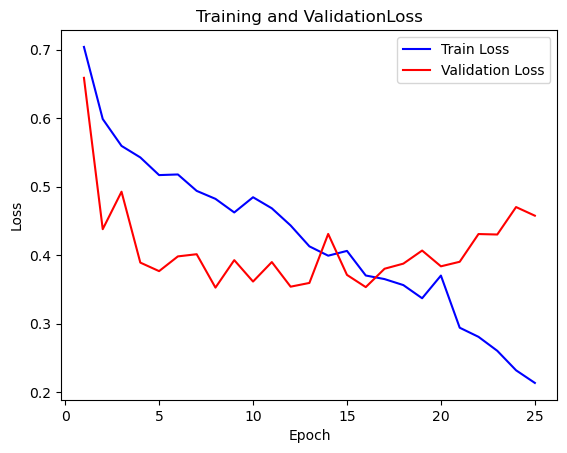

Figure Training and ValidationAccuracy saved!


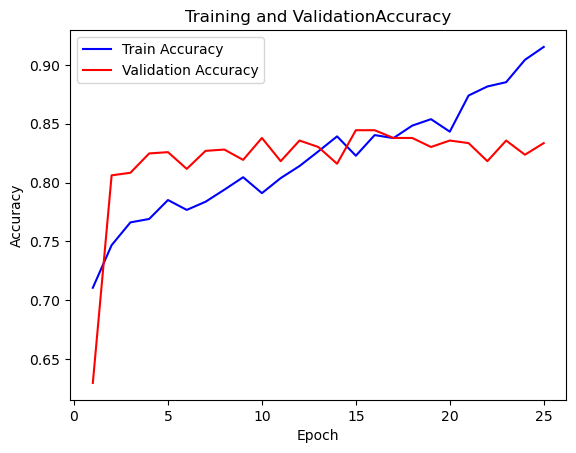

Model 9 training results saved.
Epoch 1/50
86/86 [==============================] - 21s 233ms/step - loss: 0.8752 - accuracy: 0.6862 - val_loss: 0.4369 - val_accuracy: 0.7974
Epoch 2/50
86/86 [==============================] - 19s 226ms/step - loss: 0.6664 - accuracy: 0.7716 - val_loss: 0.4055 - val_accuracy: 0.8215
Epoch 3/50
86/86 [==============================] - 19s 227ms/step - loss: 0.5824 - accuracy: 0.7855 - val_loss: 0.4059 - val_accuracy: 0.8280
Epoch 4/50
86/86 [==============================] - 19s 225ms/step - loss: 0.5398 - accuracy: 0.8009 - val_loss: 0.4148 - val_accuracy: 0.8116
Epoch 5/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4870 - accuracy: 0.8096 - val_loss: 0.4021 - val_accuracy: 0.8335
Epoch 6/50
86/86 [==============================] - 19s 227ms/step - loss: 0.4525 - accuracy: 0.8363 - val_loss: 0.4132 - val_accuracy: 0.8346
Epoch 7/50
86/86 [==============================] - 19s 225ms/step - loss: 0.4325 - accuracy: 0.8389 - val_los

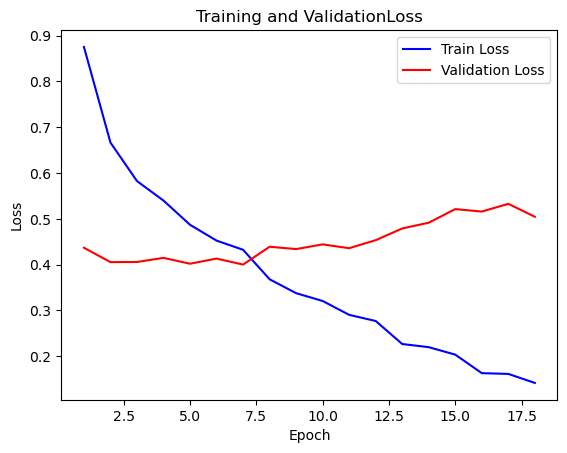

Figure Training and ValidationAccuracy saved!


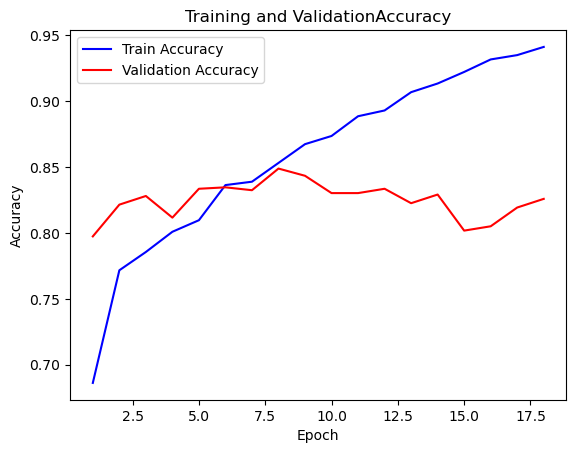

Model 10 training results saved.


In [33]:
from src.training_utils import *
from keras import backend as K

for i in range(len(best_models)):
    print('Retraining Model {}...'.format(i+1))
    
    model = build_model(best_hps[i])
    
    # Train the model
    history = model.fit(x=x_train, 
              y=y_train, 
              batch_size=32, 
              epochs=50, 
              verbose=1, 
              callbacks=[EarlyStopping(monitor='val_accuracy', 
                                       patience=10, 
                                       baseline=0.80,
                                       restore_best_weights=True)],
              validation_data=(x_validation, y_validation))
    
    model_save_dir = '{}/Model_{}_Ranking_VGG19'.format(project_dir, i+1)
    
    safe_save_training_results(hyperparams_dict=best_hps[i].values,
                               model=model,
                               model_save_type='keras', 
                               history=history, 
                               his_save_type='csv', 
                               save_dir = model_save_dir,)
    
    # Save the plot
    plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)
    
    print('Model {} training results saved.'.format(i+1))
    
    # Clear the session for the next model
    K.clear_session()

# Evaluate the best models (WARNING: don't run this cell until the final model is selected)

In [25]:
# for i in range(len(best_models)):
#     best_models[i].evaluate(x_test,y_test,verbose=1)
#     # save the evaluation results
#     with open(f'{project_dir}/best_model_{i+1}_evaluation.txt', 'w') as f:
#         original_stdout = sys.stdout
#         sys.stdout = f
#         f.write(str(best_models[i].evaluate(x_test, y_test, verbose=1)))
#         sys.stdout = original_stdout
#         f.close()

# Fine-tune the hypermodel search space

In [65]:
from src.hypermodels import create_meta_network
from keras.optimizers import Adam, SGD, RMSprop

# Overwrite the build_model function for fine-tuning hypermodel search
def build_model(hp):
    # Hyperparameters of model architecture
    img_size = 224 # VGG19 input size

    num_dense_layers = hp.Fixed('num_dense_layers', value=2)
    dense_units_list = [hp.Int(f'dense_units_{i + 1}', min_value=64, max_value=112, step=16, default=96)
                        for i in range(num_dense_layers)]
    dense_activation_list = [hp.Choice(f'dense_activation_{i + 1}', values=['relu', 'linear'],default='relu')
                             for i in range(num_dense_layers)]
    dropout_rate_list = [hp.Float(f'dropout_rate_{i + 1}', min_value=0.2, max_value=0.5, step=0.1, default=0.4)
                         for i in range(num_dense_layers)]
    score_activation = hp.Choice('score_activation', values=['tanh', 'linear'])
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=0, max_value=4, step=2, default=0)
    final_activation = hp.Fixed('final_activation', value='sigmoid')
    
    # Build the model
    meta_model = create_meta_network(img_size, num_dense_layers, dense_units_list, dense_activation_list,
                                     dropout_rate_list,
                                     score_activation, unfreeze_layers, final_activation, data_aug=True, weights=None)
    
    # Hyperparameters of model training
    optimizers = {
        'adam': Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        'sgd': SGD(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        'rmsprop': RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6]))
    }

    meta_model.compile(optimizer=optimizers[hp.Choice('optimizer', values=['adam', 'rmsprop'])],
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

    return meta_model

build_model(kt.HyperParameters())

# Make the project dir for the fine-tuning hypermodel
project_ft_model_name = 'FineTuning_Model_5-9-10_{}_{}'.format(date.today(), datetime.now().strftime("%H-%M"))
project_ft_model_dir = f'{project_dir}/{project_ft_model_name}'
os.makedirs(project_ft_model_dir, exist_ok=False)

# Define Tuner
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=100,
    # num_initial_points=None,
    # alpha=0.0001,
    # beta=2.6,
    # seed=None,
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    # max_retries_per_trial=0,
    # max_consecutive_failed_trials=3,
    overwrite=False,
    directory=project_dir,
    project_name=project_ft_model_name,
)

# Print the Search Space
tuner.search_space_summary()
with open(f'{project_ft_model_dir}/search_space.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.search_space_summary()))
    sys.stdout = original_stdout
    f.close()

# Start Tuning
tuner.search(x=x_train,
             y=y_train,
             epochs=100,
             batch_size=32,
             validation_data=(x_validation, y_validation),
             callbacks=[EarlyStopping(monitor='val_accuracy', 
                                      patience=10, 
                                      baseline=0.80,
                                      restore_best_weights=True)])

# Query the Tuning Results and save the results
tuner.results_summary()
with open(f'{project_ft_model_dir}/results_summary.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.results_summary()))
    sys.stdout = original_stdout
    f.close()
    
# Save the best models and hyperparameters
best_ft_hps = tuner.get_best_hyperparameters(num_trials=10)
best_ft_models = tuner.get_best_models(num_models=10)

for j in range(len(best_ft_models)):
    best_ft_models[j].save(f'{project_ft_model_dir}/best_model_{j + 1}.keras')
    with open(f'{project_ft_model_dir}/best_hps_{j + 1}.json', 'w') as f:
        json.dump(best_ft_hps[j].values, f, indent=4)
        
# Clear the session for the next model
K.clear_session()

# Retrain the best models of fine-tuning hypermodel search
for i in range(len(best_models)):
    print('Retraining Model {}...'.format(i+1))
    
    model = build_model(best_hps[i])
    
    # Train the model
    history = model.fit(x=x_train, 
              y=y_train, 
              batch_size=32, 
              epochs=50, 
              verbose=1, 
              callbacks=[EarlyStopping(monitor='val_accuracy', 
                                       patience=10, 
                                       baseline=0.80,
                                       restore_best_weights=True)],
              validation_data=(x_validation, y_validation))
    
    model_save_dir = '{}/Model_{}_Ranking_VGG19'.format(project_dir, i+1)
    
    safe_save_training_results(hyperparams_dict=best_hps[i].values,
                               model=model,
                               model_save_type='keras', 
                               history=history, 
                               his_save_type='csv', 
                               save_dir = model_save_dir,)
    
    # Save the plot
    plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)
    
    print('Model {} training results saved.'.format(i+1))
    
    # Clear the session for the next model
    K.clear_session()

Trial 100 Complete [00h 05m 45s]
val_accuracy: 0.8466593623161316

Best val_accuracy So Far: 0.85651695728302
Total elapsed time: 10h 27m 08s
Results summary
Results in hypermodel_tuning/BayesianOptimization_2023-10-06_21-00\FineTuning_Model_5-9-10_2023-10-07_19-22
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 036 summary
Hyperparameters:
num_dense_layers: 2
dense_units_1: 80
dense_units_2: 80
dense_activation_1: linear
dense_activation_2: relu
dropout_rate_1: 0.4
dropout_rate_2: 0.2
score_activation: linear
unfreeze_layers: 0
final_activation: sigmoid
learning_rate: 0.0001
optimizer: adam
Score: 0.85651695728302

Trial 064 summary
Hyperparameters:
num_dense_layers: 2
dense_units_1: 64
dense_units_2: 112
dense_activation_1: relu
dense_activation_2: relu
dropout_rate_1: 0.4
dropout_rate_2: 0.2
score_activation: linear
unfreeze_layers: 0
final_activation: sigmoid
learning_rate: 0.0001
optimizer: adam
Score: 0.85651695728302

Trial 065 summary
Hyperparamete